# RandomForest 분류 하이퍼 파라미터 튜닝

일반 분류 알고리즘의 튜닝 방법과 동일하다.

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# RandomForest 분류기
from sklearn.ensemble import RandomForestClassifier

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel(
    "https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 기본 전처리

In [3]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print(
        "{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(
            feature, zero_count, 100 * zero_count / total_count
        )
    )

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print(
        "{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(
            feature, zero_count, 100 * zero_count / total_count
        )
    )

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


### [4] 훈련/검증 데이터 분리 및 스케일링

In [4]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


## #02. 랜덤포레스트 하이퍼 파라미터 튜닝

### [1] RandomizedSearchCV 적용

In [5]:
%%time

# RandomForest 분류기
estimator = RandomizedSearchCV(
    estimator=get_estimator(classname=RandomForestClassifier), 
    param_distributions=get_hyper_params(classname=RandomForestClassifier), 
    n_iter=get_max_iter(),
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    cv=5
)

estimator.fit(x_train, y_train)
estimator

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 96 is smaller than n_iter=1000. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 194 ms, sys: 88.6 ms, total: 283 ms
Wall time: 5.06 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0,
                                                    verbose=False),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=0)

### [2] RandomizedSearchCV 결과 확인

In [6]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)

result_df

,n_estimators,max_features,max_depth,criterion,mean_test_score
1,20,sqrt,10.0,gini,0.763868
38,50,sqrt,NaN,gini,0.762268
14,50,sqrt,20.0,gini,0.762268
26,50,sqrt,50.0,gini,0.762268
53,20,log2,10.0,entropy,0.762228
...,...,...,...,...,...
76,10,log2,50.0,entropy,0.723137
64,10,log2,20.0,entropy,0.721511
61,20,sqrt,20.0,entropy,0.719885
85,20,sqrt,NaN,entropy,0.718259


### [3] 모델 성능 평가

컴퓨터 성능이 좋지 않을 경우 가장 부하가 큰 학습곡선 출력을 off 시킬 것

> `learning_curve=False` 파라미터 추가

+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.977199 |     0.798701 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.981395 |     0.681818 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.954751 |     0.638298 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0101781 |     0.130841 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.989822 |     0.869159 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |      0.96789 |     0.659341 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.997467 |     0.842613 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--------------

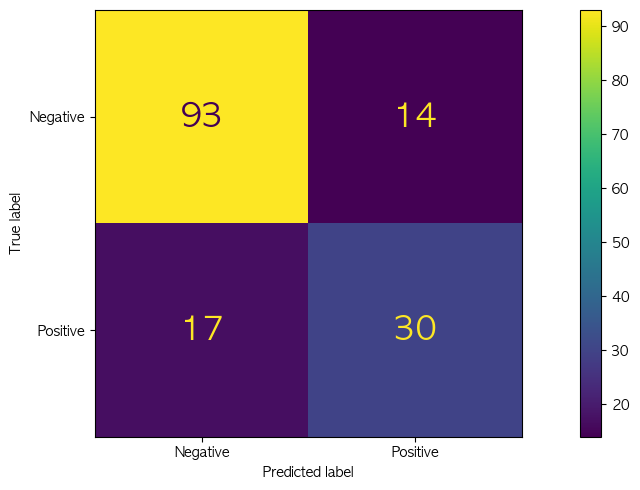

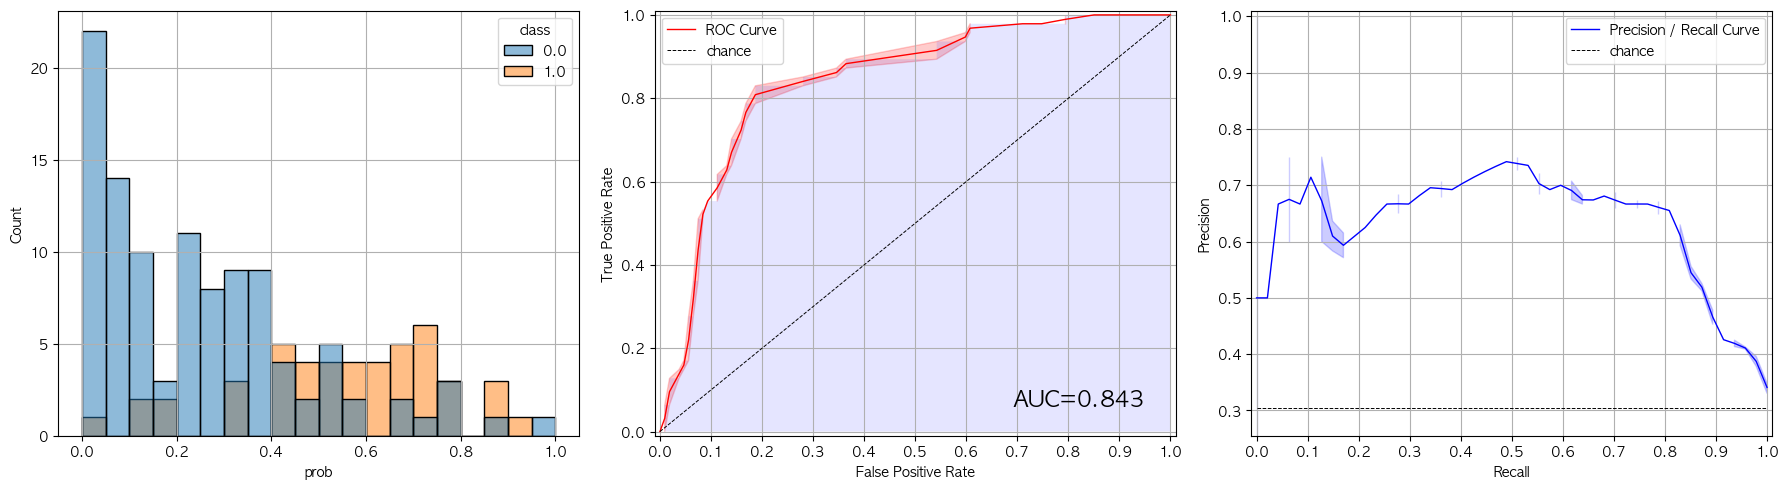

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 96 is smaller than n_iter=1000. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 96 is smaller than n_iter=1000. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 96 is smaller than n_iter=1000. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 96 

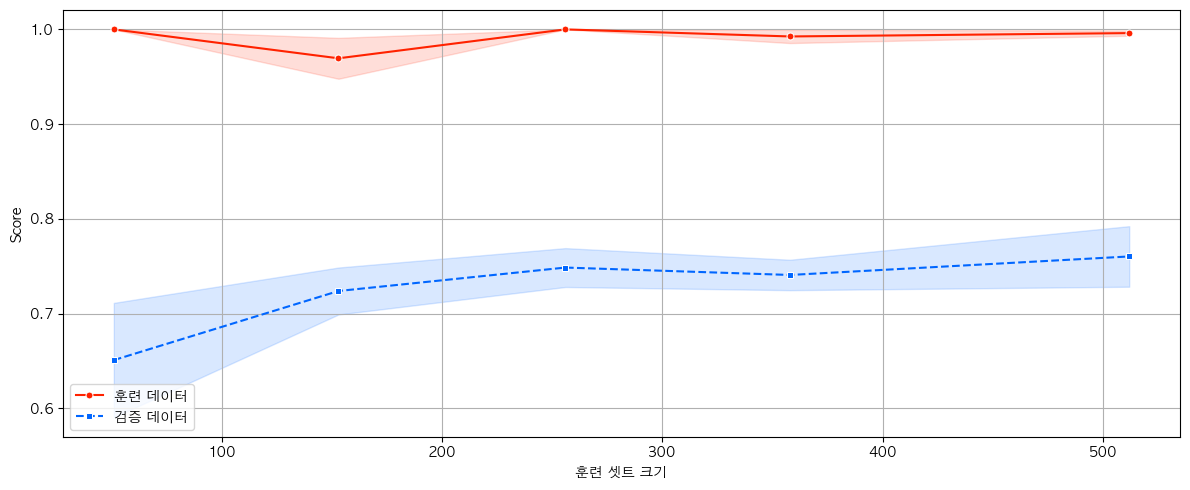

CPU times: user 1.99 s, sys: 1.89 s, total: 3.88 s
Wall time: 40.7 s


In [7]:
%%time
my_classification_result(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

### [4] 독립변수 보고

In [8]:
%%time
my_classification_report(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+
CPU times: user 18.2 ms, sys: 697 µs, total: 18.9 ms
Wall time: 2.68 ms


## #03. 모듈화 기능 확인

[교차검증 TOP5]
+----+----------------+----------------+-------------+-------------+-------------------+
|    |   n_estimators | max_features   |   max_depth | criterion   |   mean_test_score |
|----+----------------+----------------+-------------+-------------+-------------------|
|  0 |             50 | sqrt           |          50 | gini        |          0.762268 |
|  1 |            100 | log2           |          10 | entropy     |           0.75082 |
|  2 |             50 | log2           |          10 | entropy     |          0.747568 |
|  3 |             20 |                |          50 | entropy     |          0.747568 |
|  4 |             50 | sqrt           |          10 | gini        |          0.745928 |
+----+----------------+----------------+-------------+-------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini'}

+-------------------+--------------+--------------+-------------------------------------

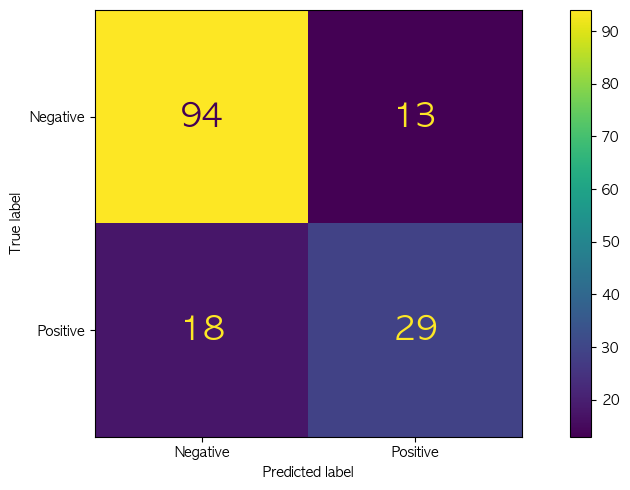

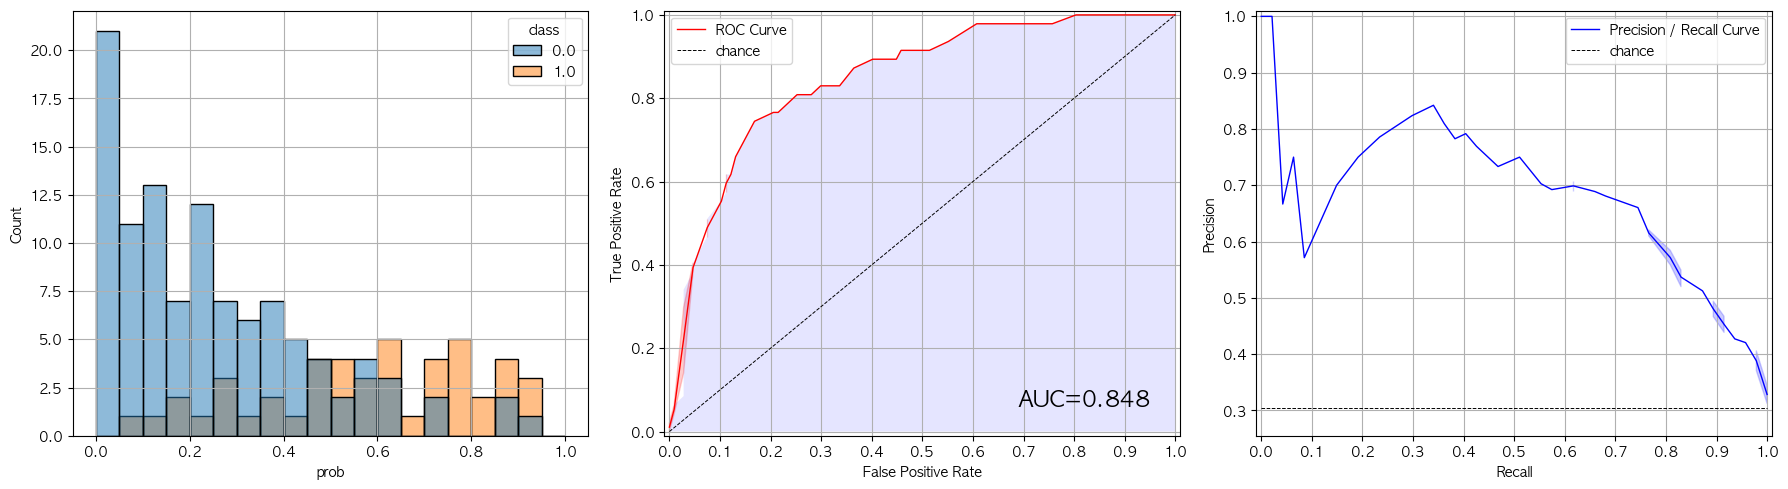

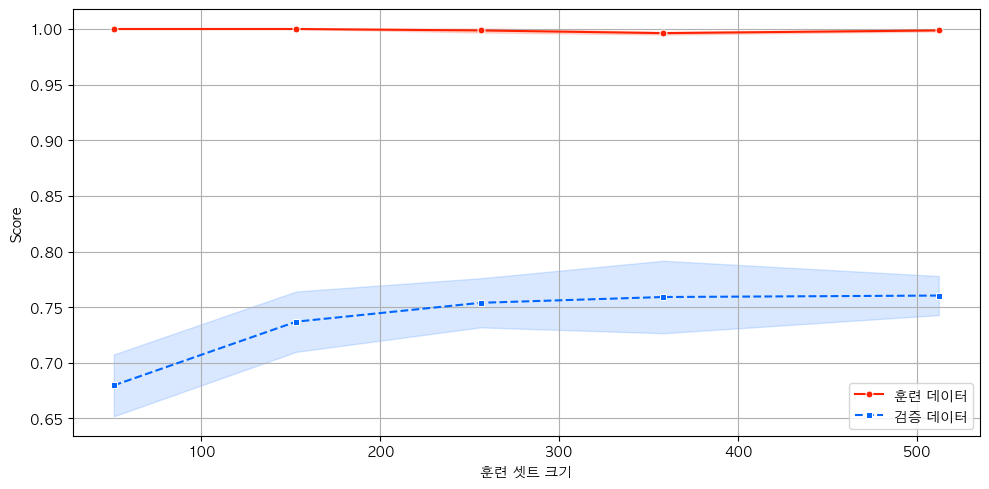

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+
CPU times: user 1.91 s, sys: 68.4 ms, total: 1.98 s
Wall time: 1.31 s


RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0,
                       verbose=False)

In [9]:
%%time
my_rf_classification(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)